# Training DETR & Deploying with MLFlow

Let's first make sure that a GPU is available.

In [2]:
!nvidia-smi

Tue Apr 27 22:35:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.56       CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:05.0 Off |                    0 |
| N/A   37C    P0    34W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install mlflow

     |████████████████████████████████| 14.2 MB 8.6 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 73.6 MB/s eta 0:00:01
     |████████████████████████████████| 82 kB 36.3 MB/s eta 0:00:01
     |████████████████████████████████| 54 kB 61.2 MB/s eta 0:00:01
     |████████████████████████████████| 94 kB 62.4 MB/s eta 0:00:01
     |████████████████████████████████| 79 kB 82.6 MB/s eta 0:00:01
     |████████████████████████████████| 75 kB 80.7 MB/s eta 0:00:01
     |████████████████████████████████| 9.5 MB 92.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.5 MB 60.1 MB/s eta 0:00:01
     |████████████████████████████████| 156 kB 90.8 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 32.1 MB/s eta 0:00:01
  Created wheel for alembic: filename=alembic-1.4.1-py2.py3-none-any.whl size=158155 sha256=0c724beeea43aa25ac82d650d3a8df0fcf07f2a96c5725cec3fa2dea7fadc068
  Stored in directory: /tmp/pip-ephem-wheel-cache-8hnn4trp/wheels/e9/7b/aa/e18c983d8236b14

## Prep imports and helper functions

In [5]:
# Imports
import sys
sys.path.append('/')
sys.path.append('/detr')
import os
import json
from attrdict import AttrDict
import json
import requests

import numpy as np
import torch
from torch import nn
import torchvision.transforms as T
import mlflow

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.backends.backend_pdf import PdfPages

from determined.experimental import Determined
from determined.pytorch import PyTorchTrialContext

sys.path.append('detr_coco_pytorch')
from data import CocoDetection, build_dataset
from model import build_model

In [18]:
# Utility functions
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# This function will help us plot images and bounding boxes with class labels.
def plot_results(pil_img, class_ids, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for cl, (xmin, ymin, xmax, ymax), c in zip(class_ids, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        text = f'{CLASSES[cl]}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')

# Standard transform
transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

# COCO Dataset

We will be working with the COCO 2017 dataset so let's first get familiar with what the data looks like.  Since the notebook you're using is launched and managed from the Determined cluster, it has already been configured to have access to a google storage bucket with COCO 2017 data.  We can just point the dataset to the right bucket to load image files.

In [7]:
dataset_val = CocoDetection(
    'gcs',
    'determined-ai-coco-dataset',
    'determined-ai-coco-dataset/val2017',
    '/tmp/instances_val2017.json',
    transforms=None,
    return_masks=False,
)

loading annotations into memory...
Done (t=0.88s)
creating index...
index created!


The COCO 2017 dataset has around 90 classes along with hierarchical grouping of classes by super category.  We will be tasked with predicting bounding boxes and classes for the granular classes.

In [8]:
dataset_val.coco.cats

{1: {'supercategory': 'person', 'id': 1, 'name': 'person'},
 2: {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 3: {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 4: {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 5: {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 6: {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 7: {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 8: {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 9: {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 10: {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 11: {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 13: {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 14: {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 15: {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 16: {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 17: {'supercategory': 'animal', 'id': 17, 'name': 'cat'},

Let's take a look at one of the images along with the associated target bounding boxes and classes.  As you can see, boxes can overlap and there can be multiple instances of the same object in one image.

In [9]:
datapoint = dataset_val[237]

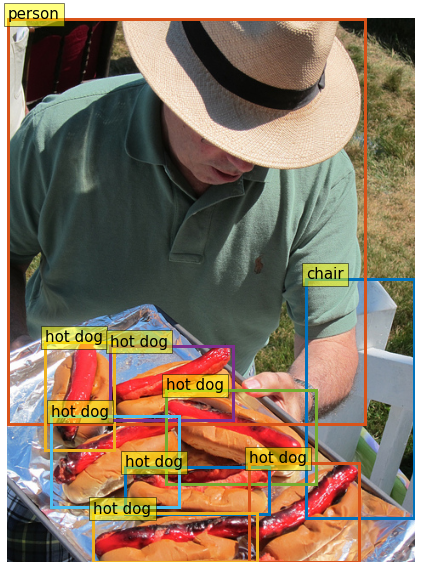

In [10]:
plot_results(datapoint[0], datapoint[1]['labels'], datapoint[1]['boxes'])    


In [11]:
# DETR in Determined
from model_def import DETRTrial

In [12]:
??DETRTrial

Init signature: DETRTrial(context:determined.pytorch._pytorch_context.PyTorchTrialContext) -> None
Docstring:     
PyTorch trials are created by subclassing this abstract class.

We can do the following things in this trial class:

* **Define models, optimizers, and LR schedulers**.

   Initialize models, optimizers, and LR schedulers and wrap them with
   ``wrap_model``, ``wrap_optimizer``, ``wrap_lr_scheduler`` provided by
   :class:`PyTorchTrialContext <determined.pytorch.PyTorchTrialContext>`
   in the :meth:`__init__`.

* **Run forward and backward passes**.

   Call ``backward`` and ``step_optimizer`` provided by
   :class:`PyTorchTrialContext <determined.pytorch.PyTorchTrialContext>` in :meth:`train_batch`.
   Note that we support arbitrary numbers of models, optimizers, and LR schedulers
   and arbitrary orders of running forward and backward passes.

* **Configure automatic mixed precision**.

   Call ``configure_apex_amp`` provided by
   :class:`PyTorchTrialContext <determine

# Submit experiment to Determined Cluster

Once the trial definition is ready to go, we can configure an experiment with the desired hyperparameters and resources with a `.yaml` config file.  This separation between config and code promotes reproducibility down the road.  We also track the environment and code used for each experiment so that users can easily replicate their results in the future.  

The magic of Determined is that users need to change very few things to run advanced ML workflows such as multi-node distributed training and advanced hyperparameter search.  

In [13]:
! cat detr_coco_pytorch/finetune_gcs.yaml

description: detr_coco
hyperparameters:
    lr: 1e-4
    lr_backbone: 0
    global_batch_size: 4
    weight_decay: 1e-4
    lr_drop: 4
    clip_max_norm: 0.1

    # Backbone
    backbone: resnet50
    dilation: false
    position_embedding: sine

    # Transformer
    enc_layers: 6
    dec_layers: 6
    dim_feedforward: 2048
    hidden_dim: 256
    dropout: 0.1
    nheads: 8
    num_queries: 100
    pre_norm: false

    # Loss
    aux_loss: true

    # Matcher
    set_cost_class: 1
    set_cost_bbox: 5
    set_cost_giou: 2

    # Loss Coefficients
    mask_loss_coef: 1
    dice_loss_coef: 1
    bbox_loss_coef: 5
    giou_loss_coef: 2
    eos_coef: 0.1

    # Dataset
    dataset_file: coco
    backend: gcs
    data_dir: determined-ai-coco-dataset
    cat_ids: 
        - 21
    num_classes: 1
    masks: false
    num_workers: 4

    device: cuda

bind_mounts:
    - host_path: /tmp
      container_path: /data
      read_only: false

min_validation_period:
    epochs: 1
records_per_epoch: 

### You can test this out by running `det e create finetune_gcs.yaml .` from the `detr_coco_pytorch` folder using the terminal.

# Configure HP search experiment

To tune hyperparameters of our finetune experiment, we simply need to modify a few fields in the experiment config.

In [14]:
! cat detr_coco_pytorch/finetune_adaptive.yaml

description: detr_coco
hyperparameters:
    lr: 
        type: double
        minval: 1e-5
        maxval: 1e-4
    lr_backbone: 0
    global_batch_size: 4
    weight_decay: 1e-4
    lr_drop: 4
    clip_max_norm: 
        type: double
        minval: 0.1
        maxval: 0.5

    # Backbone
    backbone: resnet50
    dilation: false
    position_embedding: sine

    # Transformer
    enc_layers: 6
    dec_layers: 6
    dim_feedforward: 2048
    hidden_dim: 256
    dropout: 0.1
    nheads: 8
    num_queries: 100
    pre_norm: false

    # Loss
    aux_loss: true

    # Matcher
    set_cost_class: 1
    set_cost_bbox: 5
    set_cost_giou: 2

    # Loss Coefficients
    mask_loss_coef: 1
    dice_loss_coef: 1
    bbox_loss_coef: 5
    giou_loss_coef: 2
    eos_coef: 0.1

    # Dataset
    dataset_file: coco
    backend: gcs
    data_dir: determined-ai-coco-dataset
    cat_ids: 
        - 21
    num_classes: 1
    masks: false
    num_workers: 4

    device: cuda

bind_mounts:
    - host_pa

### You can test this out by running `det e create finetune_adaptive.yaml .` from the `detr_coco_pytorch` folder using the terminal.

# Loading models from registry

After an experiment finishes running, we can track the resulting checkpoints if desired in the model registry.  This can be done through the command line (see below) or programmatically with python.  

`det model create <model_name>`

`det model register-version <model_name> <checkpoint_uuid>`

Once a checkpoint has been registered under a model, it can be easily accessed for future use.

In [15]:
model = Determined().get_model("detr")
ckpt = model.get_version()
ckpt_path = ckpt.download()
ckpt = torch.load(os.path.join(ckpt_path, 'state_dict.pth'))
metadata = json.load(open(os.path.join(ckpt_path, 'metadata.json'), 'r'))
hparams = AttrDict(metadata['hparams'])
model, _, postprocessor = build_model(hparams, 1)
model.load_state_dict(ckpt['models_state_dict'][0])

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


<All keys matched successfully>

# Deploying the model using MLFlow

In [16]:
# We need to wrap the model and modify the output to return a single tensor since that is the expected output for MLFlow models.
class WrappedDETR(nn.Module):
    def __init__(self, model):
        super(WrappedDETR, self).__init__()
        self.model = model.float()
    def forward(self, inputs):
        if not next(self.model.parameters()).is_cuda:
            self.model = self.model.float().cuda()
        inputs = inputs.float().cuda()
        outputs = self.model(inputs)
        return torch.cat((outputs['pred_logits'], outputs['pred_boxes']), dim=2).cpu()

In [17]:
new_model = WrappedDETR(model)
mlflow.pytorch.save_model(
    new_model, 
    "mlflow_model", 
    conda_env="conda.yaml", # setup conda env with necessary dependencies
    code_paths=[
        "/detr",
        "/detr/util",
        "/detr/models",
        "/detr/datasets",
        "./detr_coco_pytorch"
    ] # include all code files needed to load DETR model
)

/opt/conda/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type WrappedDETR. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


The next step is to launch a server for our model by running the command below in a terminal window:

`mlflow models serve -m mlflow_model &`

## Sending prediction request via REST API

In [19]:
def get_prediction(img_list):
    url = 'http://127.0.0.1:5000/invocations'
    req = requests.post(url, json={"instances": img_list}, headers={'Content-Type': 'application/json'})
    return req

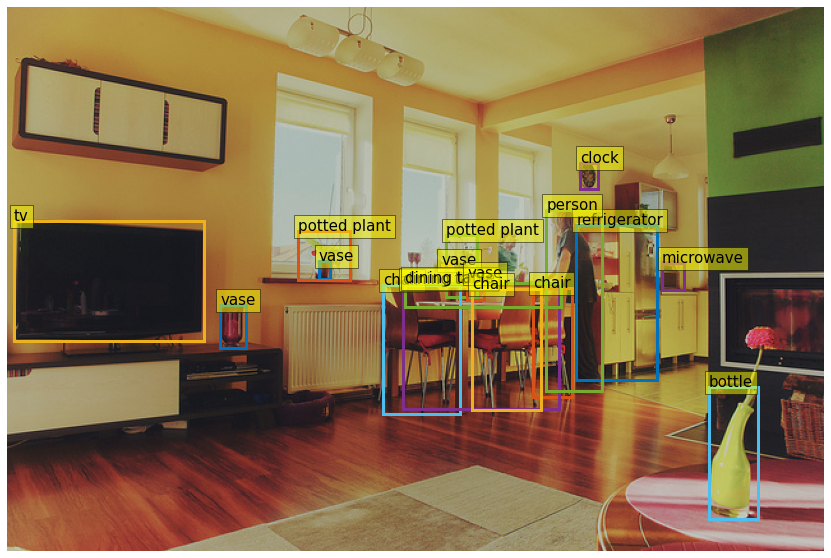

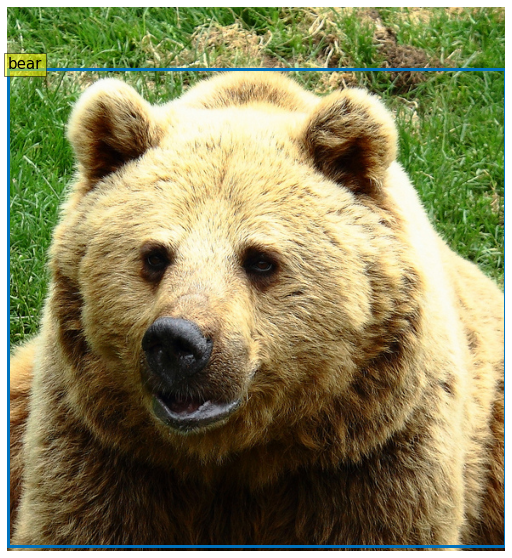

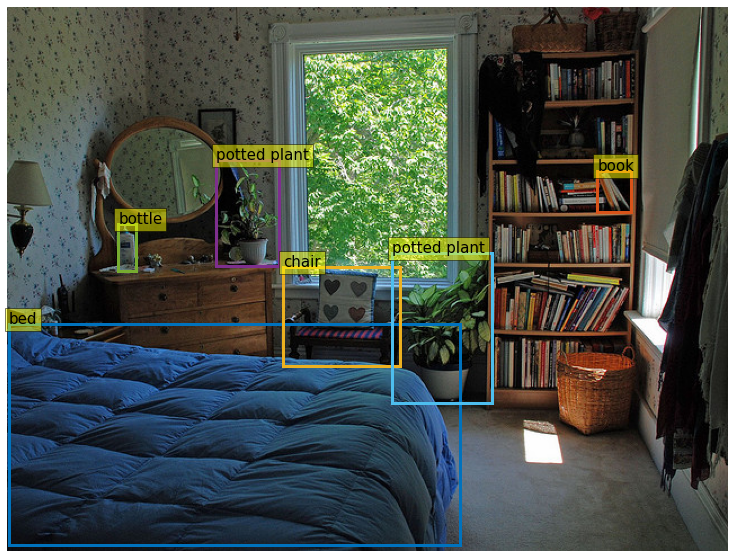

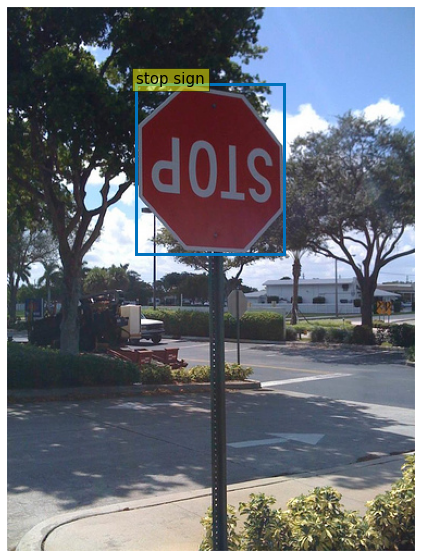

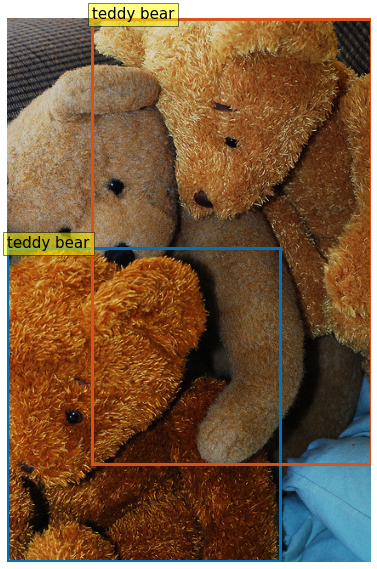

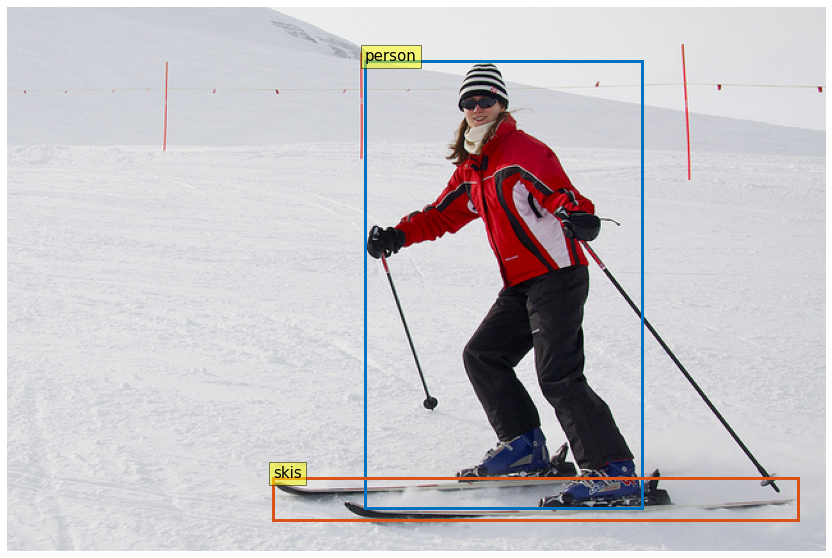

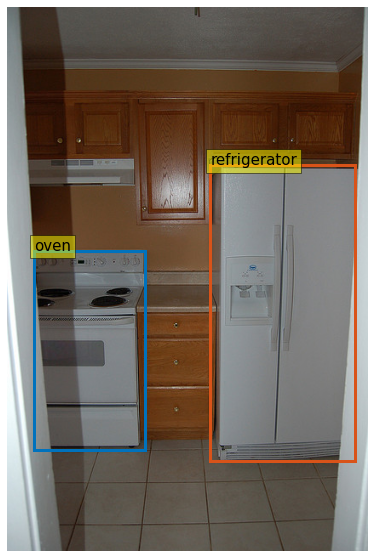

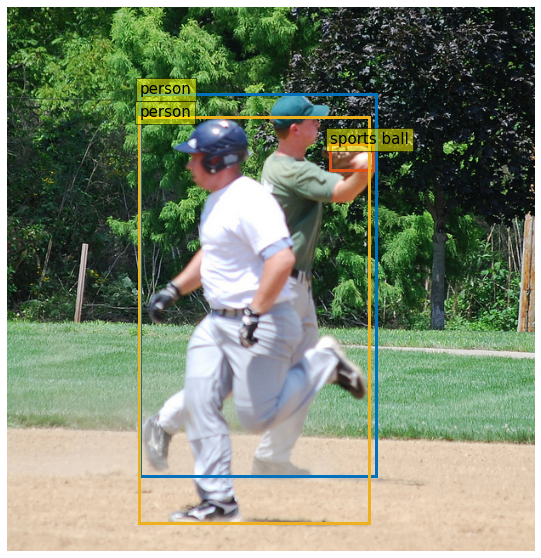

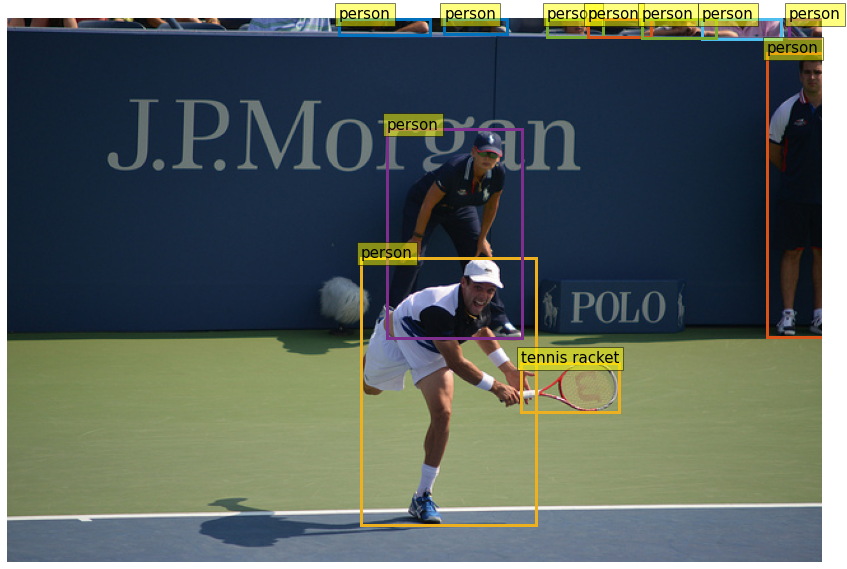

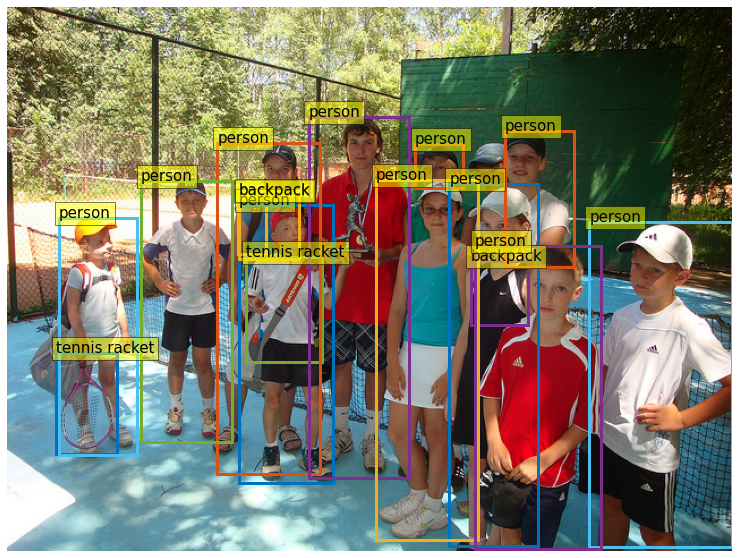

In [26]:
pdf = PdfPages("predictions.pdf")
for i in range(10):
    raw_img = dataset_val[i][0]
    img = transform(raw_img).unsqueeze(0)
    img_list = np.array(img).tolist()
    # We can send json serializable objects to the REST API endpoint for prediction.
    req = get_prediction(img_list)
    prediction = json.JSONDecoder().decode(req.text)
    prediction = torch.tensor(np.array(prediction))
    outputs = {
        'pred_logits': prediction[:, : ,:-4],
        'pred_boxes': prediction[:, : ,-4:],
    }
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.9
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], raw_img.size)
    plot_results(raw_img, probas[keep].argmax(-1), bboxes_scaled)
    pdf.savefig()
pdf.close()